# Lab 3: KNN and Decision Trees


In this lab we'll get some hands on experience with two of the classifiers we've seen in class
- K Nearest Neighbors
- Decision Trees

## Goals for this lab

- Understand the practical implications for changing the parameters used in KNearest Neighbor Classifier
  - k
  - distance metric
  - weighting method
  
  
- Understand the practical implications for changing the parameters used in Decision Trees

 - splitting criteria (gini vs information gain)
 - max depth
 - min sample size for split
 
- Understand how to interpret Decision Trees

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import graphviz # If you don't have this, install via pip/conda
%matplotlib inline

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data
We'll use these classifiers on a small dataset on world happiness metrics:
https://www.kaggle.com/unsdsn/world-happiness/

Download the data from 2015 or 2016 and load it. Note: the 2017 data is missing the Region column so don't use that.

You should also try this with other data sets you have been provided for the homeworks.

In [3]:
# Change this to wherever you're storing your data
dfile = '2015.csv'
df = pd.read_csv(dfile)

In [4]:
df.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

In [221]:
df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


# Some Quick Data Exploration
Before running any sort of model on your dataset, it's always a good idea to do some quick data exploration to get a sense of how your data looks like. Try to answer the following questions with some sort of plot/histogram/etc:

1) What do the distributions of each feature look like?

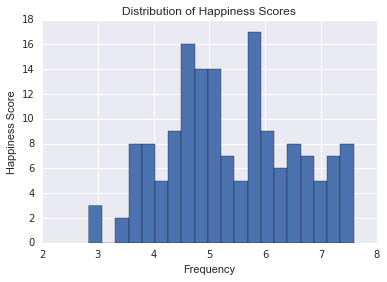

In [222]:
# Ex
plt.hist(df['Happiness Score'], bins=20)
plt.title('Distribution of Happiness Scores')
plt.ylabel('Happiness Score')
plt.xlabel('Frequency')
plt.show()

2) Do countries from the same region have similar feature values? (To save on time so that you're not generating hundreds of plots, you can just pick one or two regions, and look at whichever features look most interesting).

Hint: consider using [pandas' groupby function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) or doing a manual filter

In [38]:
seaDF = df.loc[df["Region"] == "Southeastern Asia", :]

In [46]:
seaDF.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

In [45]:
import seaborn as sns

In [48]:
def basic_hist(df, x):
	sns.distplot(df[x])
	plt.show()
	return

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


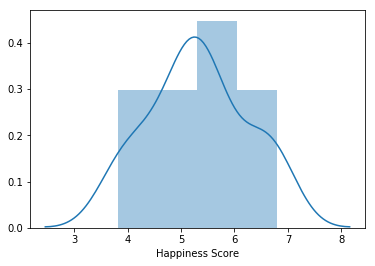

In [49]:
basic_hist(seaDF, "Happiness Score")

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


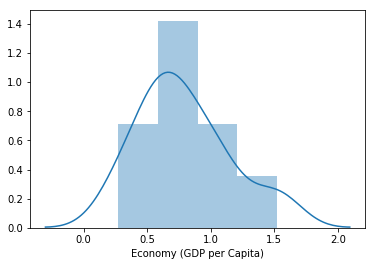

In [50]:
basic_hist(seaDF, "Economy (GDP per Capita)")

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


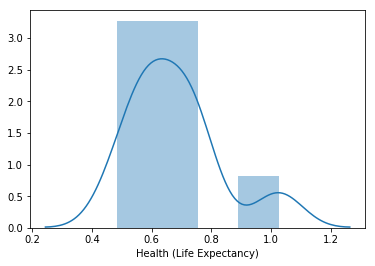

In [51]:
basic_hist(seaDF, "Health (Life Expectancy)")

In [23]:
region_groupDF.Region

3) Which features are least correlated with "Happiness"?

Hint: Plotting this is a good idea. Also consider using [pandas' correlation function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)

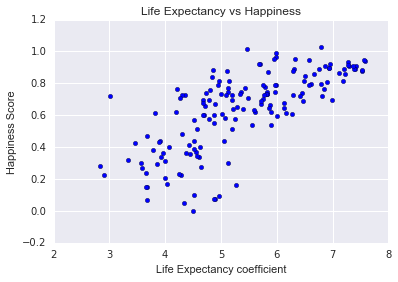

In [208]:
# Example plot
plt.scatter(df['Happiness Score'], df['Health (Life Expectancy)'])
plt.title('Life Expectancy vs Happiness')
plt.xlabel('Life Expectancy coefficient') # units unclear...
plt.ylabel('Happiness Score')
plt.show()

## Classification
A natural thing to do with this dataset is to try to use the various feature columns to predict each country's "Happiness Score" via some regression model. But in this class we're mostly going to focus on classification. So let's create a toy column so that we have a classification task: create a binary 'In Europe' column. We can do this by checking if "Europe" is contained in the "Region" column of each row.

In [57]:
df['In Europe'] = df['Region'].apply(lambda x: 'Europe' in x)

Before we can use any of the classifiers, we need to pick which features we want to drop/keep.

In [58]:
df.drop(['Region', 'Happiness Rank'], axis=1, inplace=True)
df.head()

,Country,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,In Europe
0,Switzerland,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,True
1,Iceland,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,True
2,Denmark,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,True
3,Norway,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,True
4,Canada,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,False


# Train/Test Splits

Create a train/test set split using sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We'll use these train/test splits for evaluating all our classification models.

In [59]:
countries = df['Country'] # useful later for reindexing
X = df.drop(['In Europe', 'Country'], axis=1)
Y = df['In Europe']
test_size = 0.3 # you can adjust this
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

# K Nearest Neighbors
See the sklearn documentation on the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) to see its parameters. The one's we'll mostly be interested in are:
- n_neighbors
- distance metric
- weighting function

## KNN Distance Function
Something important to note is that the KNN algorithm requires a "metric" or a notion of distance. If you don't set this parameter, it defaults to the Euclidean distance. Do you think the Euclidean distance is appropriate in this setting? You can set the metric parameter to any one of the distance metrics defined under the sklearn [DistanceMetric class](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Different metrics might have different parameters which you can set like so:

In [226]:
# If your metric has a metric parameter you need to pass that in via a
# dictionary to metric_params.
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean', metric_params={'p': 3})

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Remember that when training a model, **you should only use the training data!** The test set is reserved exclusively for evaluating your model. Now let's use the classifier:

In [63]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
knn.predict(x_test)

array([ True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
       False,  True, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
        True, False,  True])

## KNN Tasks:

1) Write a function that computes the accuracy of the predicted values



In [250]:
def evaluateAccuracy(clf,predictDF, truthDF):
    correct_pred = 0
    pred_x = clf.predict(predictDF)
    for i in range(0,len(predictDF)):
        if pred_x[i] == truthDF.iloc[i]:
            correct_pred +=1
    return (correct_pred/len(predictDF))

In [251]:
evaluateAccuracy(knn, x_test,y_test)

0.7083333333333334

2) Play around with the n_neighbors value. Fit your data on the training data(x_train, y_train). Then evaluate it on both the training data, and the testing data. How does the accuracy of your train and test set predictions change as you increase n_neighbors?


It seems that the performing on the training set decreases as k increases. The performance on the testing set increases at k = 3, but then drops as k increases as well.

In [252]:
# try k = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

1.0
0.7708333333333334


In [108]:
# try k = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.8363636363636363
0.8125


In [110]:
# try k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.7909090909090909
0.7708333333333334


In [106]:
# try k = 10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.7454545454545455
0.75


In [107]:
# try k = 20
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.6818181818181818
0.75


In [111]:
# try k = 30
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.6727272727272727
0.7291666666666666


In [114]:
# try k = 50
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.6727272727272727
0.7083333333333334


3) The KNeighborsClassifier also has a [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba) function. Which countries is the classifier most/least confident about?

In [147]:
confidence = knn.predict_proba(x_test)
x_test2 = x_test.reset_index()

In [175]:
country_no = []
max_prob = []
for i in range(0, len(x_test2)):
    country_no.append(x_test2.iloc[i,0])
    max_prob.append(max(confidence[i]))

In [177]:
tempDF = pd.DataFrame({'a': country_no,
                      'b': max_prob})

In [189]:
for i in range(0, len(tempDF)):
    tempDF['cname'][i] = countries[tempDF['a'][i]]

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [191]:
tempDF.sort_values('b', ascending = False)[:3]

,a,b,cname
18,147,0.78,Central African Republic
25,152,0.78,Afghanistan
31,130,0.78,Malawi


In [192]:
tempDF.sort_values('b', ascending = True)[:3]

,a,b,cname
45,72,0.54,Estonia
26,44,0.56,Slovakia
34,53,0.56,Kazakhstan


4) You can see what datapoints are closest to a given query point via the [kneighbors function](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). What countries are closest to Switzerland? United States? Your favorite country?

In [194]:
df[df["Country"]=="Switzerland"]

,Country,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,In Europe
0,Switzerland,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,True


In [210]:
x_train2 = x_train.reset_index()

In [216]:
x_train2[x_train2["index"] == 0].drop("index", axis = 1)

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
17,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738


In [222]:
knn.kneighbors(x_train2[x_train2["index"] == 0].drop("index", axis =1), 3)

(array([[0.        , 0.1410828 , 0.14210154]]), array([[17, 64, 65]]))

In [224]:
print(countries[17])
print(countries[64])
print(countries[65])

Ireland
Jamaica
North Cyprus


5) Use a different metric for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [227]:
knn = KNeighborsClassifier(n_neighbors=10,  metric='manhattan')
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

0.7727272727272727
0.75


6) Use a different weighting function for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [228]:
knn = KNeighborsClassifier(n_neighbors=10,  metric='manhattan', weights = "distance")
knn.fit(x_train, y_train)
print(evaluateAccuracy(knn, x_train,y_train))
print(evaluateAccuracy(knn, x_test,y_test))

1.0
0.8125


## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame

### pseudocode

- for k in 1,2,3,4,5...10
  - for distance metric in (metric1, metric2,...)
    - for weighting function in (uniform, distance weighted)
      - train model
      - score test data
      - evaluate - calculate metrics
      - store parameters and evaluation metric in data frame
- print dataframe


     

In [237]:
def try_many_par_KNN():
	k_list = [3,5,8,10, 13,15,20,25,30,50]
	distance_list = ["euclidean", "manhattan", "chebyshev" ]
	weights_list = ["uniform", "distance"]


	k_rec = []
	dist_rec = []
	weights_rec = []
	tr_acc_rec = []
	test_acc_rec = []

	for index, row in enumerate(k_list):
		for index_d, row_d in enumerate(distance_list):
			for index_w, row_w in enumerate(weights_list):
				knn = KNeighborsClassifier(n_neighbors= row,  metric= row_d, weights = row_w)
				knn.fit(x_train, y_train)
				k_rec.append(row)
				dist_rec.append(row_d)
				weights_rec.append(row_w)
				tr_acc_rec.append(evaluateAccuracy(knn, x_train, y_train))
				test_acc_rec.append(evaluateAccuracy(knn, x_test, y_test))

	finalDF = pd.DataFrame({'k': k_rec,
	                      'dist': dist_rec,
	                      'weights': weights_rec,
	                      'train_acc': tr_acc_rec,
	                      'test_acc': test_acc_rec})

	return finalDF



In [240]:
finalDF = try_many_par_KNN()

In [241]:
finalDF.head(3)

,dist,k,test_acc,train_acc,weights
0,euclidean,3,0.812500,0.836364,uniform
1,euclidean,3,0.812500,1.000000,distance
2,manhattan,3,0.833333,0.900000,uniform


In [242]:
# 10 best performing on test set
finalDF.sort_values('test_acc', ascending= False)[:10]

,dist,k,test_acc,train_acc,weights
8,manhattan,5,0.875000,0.836364,uniform
9,manhattan,5,0.875000,1.000000,distance
2,manhattan,3,0.833333,0.900000,uniform
3,manhattan,3,0.833333,1.000000,distance
4,chebyshev,3,0.833333,0.790909,uniform
15,manhattan,8,0.833333,1.000000,distance
0,euclidean,3,0.812500,0.836364,uniform
13,euclidean,8,0.812500,1.000000,distance
21,manhattan,10,0.812500,1.000000,distance
1,euclidean,3,0.812500,1.000000,distance


###  You cn now use this data frame to analyze the results and see how the model performs as you modify the parameters

# Decision Trees

Moving onto decision trees. The [DecisionTreeClassifier constructor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) can take a number of parameters. You should look at all the available 
- criterion: string, "gini' for Gini Impurity or 'entropy' for information gain
- splitter: string,  "best" or 'random'
- max_features: the number of features to consider when looking for the best split.
- max_depth: int, the maximum depth of the tree.
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: min number of samples required to be at a leaf node.
- max_leaf_nodes: max number of leaf nodes a tree can have

We can do the same fit/predict/predict_proba:

In [244]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)
# dec_tree.predict(x_train)
# dec_tree.predict_proba(y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We'll be interested in how each of these parameters will affect the performance of a Decision Tree classifier.

For example: Increasing max_depth this should increase your model's ability to explain the data and eventually overfit the training data once it's high enough. The performance on the test set should degrade a bit as the training set is overfitted.

In [246]:
from sklearn.metrics import accuracy_score as accuracy

In [283]:
depths = [1, 3, 5, 7, 9]
for d in depths:
    dec_tree = DecisionTreeClassifier(max_depth=d)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(d, train_acc, test_acc))

Depth: 1 | Train acc: 0.76 | Test acc: 0.73
Depth: 3 | Train acc: 0.92 | Test acc: 0.65
Depth: 5 | Train acc: 0.97 | Test acc: 0.60
Depth: 7 | Train acc: 1.00 | Test acc: 0.58
Depth: 9 | Train acc: 1.00 | Test acc: 0.58


## Decision Tree Tasks
1) Repeat the above with each parameter in DecisionTreeClassifier. What range of values makes sense for each parameter?
(IE: does it make sense to have max_depth greater than 7 or 8 for this dataset?)

In [262]:
depths = [1, 3, 5, 7, 9,15,20]
for d in depths:
    dec_tree = DecisionTreeClassifier(max_depth=d)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(d, train_acc, test_acc))

Depth: 1 | Train acc: 0.76 | Test acc: 0.73
Depth: 3 | Train acc: 0.92 | Test acc: 0.65
Depth: 5 | Train acc: 0.96 | Test acc: 0.60
Depth: 7 | Train acc: 1.00 | Test acc: 0.56
Depth: 9 | Train acc: 1.00 | Test acc: 0.60
Depth: 15 | Train acc: 1.00 | Test acc: 0.56
Depth: 20 | Train acc: 1.00 | Test acc: 0.60


2) What do you think will happen if you normalize/scale one of the features of your dataset before passing it into the DecisionTreeClassifier.fit function? Try modifying one of your columns and rerun the evaluations above.
Do the results change? Why does/doesnt this change the resulting model?

In [270]:
x_test.head()

,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
142,3.896,0.04547,1.06024,0.90528,0.43372,0.31914,0.11091,0.06822,0.99895
73,5.399,0.02596,0.82827,1.08708,0.63793,0.46611,0.00000,0.51535,1.86399
139,3.956,0.04797,0.23906,0.79273,0.36315,0.22917,0.19900,0.17441,1.95812
91,5.013,0.03420,0.73479,0.64095,0.60954,0.41691,0.08546,0.07172,2.45373
93,4.971,0.07896,0.08308,1.02626,0.09131,0.34037,0.15603,0.22269,3.05137


In [271]:
from sklearn import preprocessing

In [277]:
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
xtest_scaled = min_max_scaler.fit_transform(x_test)
xtrain_scaled = min_max_scaler.fit_transform(x_train)

In [278]:
df1_normalized = pd.DataFrame(xtest_scaled)
df2_normalized = pd.DataFrame(xtrain_scaled)

In [280]:
depths = [1, 3, 5, 7, 9,15,20]
for d in depths:
    dec_tree = DecisionTreeClassifier(max_depth=d)
    dec_tree.fit(df2_normalized, y_train)
    train_pred = dec_tree.predict(df2_normalized)
    test_pred = dec_tree.predict(df1_normalized)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(d, train_acc, test_acc))

Depth: 1 | Train acc: 0.76 | Test acc: 0.75
Depth: 3 | Train acc: 0.92 | Test acc: 0.77
Depth: 5 | Train acc: 0.97 | Test acc: 0.73
Depth: 7 | Train acc: 1.00 | Test acc: 0.69
Depth: 9 | Train acc: 1.00 | Test acc: 0.75
Depth: 15 | Train acc: 1.00 | Test acc: 0.77
Depth: 20 | Train acc: 1.00 | Test acc: 0.69


It doesn't appear to change.

3) How does changing the "criterion" parameter affect your model. Is Gini better than Information Gain? Do not change the other parameters(max_depth, min_sample_split, etc) while doing this.

In [268]:
def try_crit_DT():

    #the parameters that I want to test
    crit_list = ["gini", "entropy"]

    #create empty lists
    rec_crit = []
    rec_trainP = []
    rec_testP = []

    #loop over every combination of the parameters
    for index_c, crit_par in enumerate(crit_list):
        dec_tree = DecisionTreeClassifier(criterion = crit_par)
        dec_tree.fit(x_train, y_train)
        # evaluate accuracy
        train_acc = evaluateAccuracy(dec_tree, x_train, y_train)
        test_acc = evaluateAccuracy(dec_tree, x_test, y_test)

        #append things to the lists
        rec_crit.append(crit_par)
        rec_trainP.append(train_acc)
        rec_testP.append(test_acc)

    #stich into a pandas DF
    finalDF = pd.DataFrame({"criterion": rec_crit,
    "prediction_train": rec_trainP,
    "prediction_test": rec_testP 
    })

    return finalDF

In [269]:
try_crit_DT()

,criterion,prediction_test,prediction_train
0,gini,0.583333,1.0
1,entropy,0.666667,1.0


Entropy appeas to perform better on the test set.

4) Decision Trees are widely used in practice because they're very interpretable. Check out the [feature_importances](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of the DecisionTreeClassifier. What features are the most informative according to this model?

In [284]:
dec_tree.feature_importances_

array([0.02752753, 0.04982922, 0.04717722, 0.17472417, 0.26635669,
       0.06056056, 0.29547034, 0.07835426, 0.        ])

## Visualizing a Decision Tree
We can visualize decision trees by exporting the model in graphviz format using the [sklearn.tree.export_graphviz function](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html). This can be very useful in diagnosing potential issues with your Decision Tree Classifier giving you poor results.

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


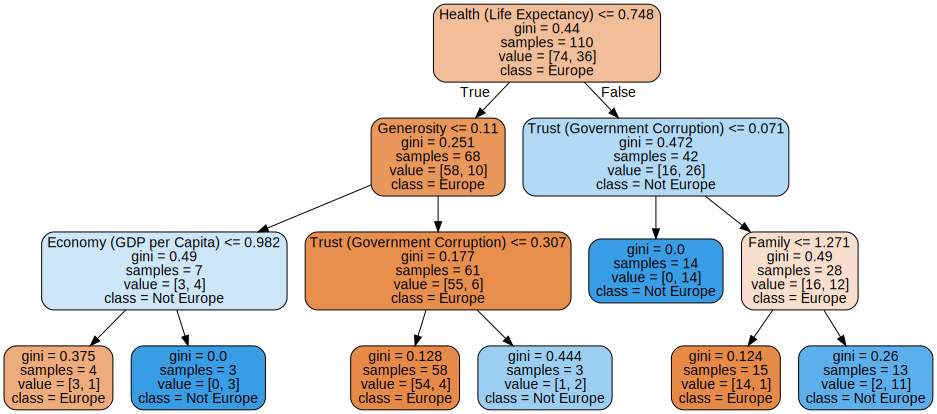

In [249]:
dec_tree = DecisionTreeClassifier(max_depth=3)
dec_tree.fit(x_train, y_train)
viz = tree.export_graphviz(dec_tree, feature_names=x_train.columns,
                           class_names=['Europe', 'Not Europe'],
                           rounded=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
graph

You should see something like:

![Decision Tree visualized](imgs/dt.png)

5) Visualize the decision tree of your best performing decision tree. Is there anything surprising about the splits that are most informative of this classification task?

In [201]:
# CODE

## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame




In [253]:
def try_many_par_DT():

    #the parameters that I want to test
    crit_list = ["gini", "entropy"]
    splitter_list = ["best", "random"]
    maxfeat_list = [None, "auto", "sqrt", "log2", 5, 0.3 ]
    maxdepth_list = [1, 3, 5, 7, 9 ,15 ,20]
    minsplit_list = [2, 3, 4, 5]
    minleaf_list = [1,2,3,4,5]
    maxleaf_list = [None, 2, 3 ,4, 5]

    #create empty lists
    rec_crit = []
    rec_split = []
    rec_maxfeat = []
    rec_maxdepth = []
    rec_minsplit = []
    rec_minleaf = []
    rec_maxleaf = []
    rec_trainP = []
    rec_testP = []

    #loop over every combination of the parameters
    for index_c, crit_par in enumerate(crit_list):
        for index_s, split_par in enumerate(splitter_list):
            for index_f, maxfeat_par in enumerate(maxfeat_list):
                for index_d, maxdepth_par in enumerate(maxdepth_list):
                    for index_ms, minsplit_par in enumerate(minsplit_list):
                        for index_ml, minleaf_par in enumerate(minleaf_list):
                            for index_maxleaf, maxleaf_par in enumerate(maxleaf_list):

                                #initialize classifier
                                dec_tree = DecisionTreeClassifier(criterion = crit_par, splitter = split_par, max_depth = maxdepth_par, min_samples_split = minsplit_par, max_features = maxfeat_par, min_samples_leaf = minleaf_par, max_leaf_nodes = maxleaf_par)
                                dec_tree.fit(x_train, y_train)

                                # evaluate accuracy
                                train_acc = evaluateAccuracy(dec_tree, x_train, y_train)
                                test_acc = evaluateAccuracy(dec_tree, x_test, y_test)

                                #append things to the lists
                                rec_crit.append(crit_par)
                                rec_split.append(split_par)
                                rec_maxfeat.append(maxfeat_par)
                                rec_maxdepth.append(maxdepth_par)
                                rec_minsplit.append(minsplit_par)
                                rec_minleaf.append(minleaf_par)
                                rec_maxleaf.append(maxleaf_par)
                                rec_trainP.append(train_acc)
                                rec_testP.append(test_acc)

    #stich into a pandas DF
    finalDF = pd.DataFrame({"criterion": rec_crit,
                            "splitter": rec_split,
                            "max_features": rec_maxfeat,
                            "max_depth": rec_maxdepth,
                            "min_samples_split": rec_minsplit,
                            "min_samples_leaf": rec_minleaf,
                            "max_leaf_nodes": rec_maxleaf,
                            "prediction_train": rec_trainP,
                            "prediction_test": rec_testP 
                            })

    return finalDF

In [256]:
various_dt_df = try_many_par_DT()

In [260]:
various_dt_df.sort_values("prediction_test", ascending = False).head()

,criterion,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,prediction_test,prediction_train,splitter
14425,entropy,9,sqrt,NaN,1,3,0.895833,0.918182,random
4885,gini,20,None,NaN,3,5,0.895833,0.872727,random
6958,gini,20,log2,4.0,2,4,0.875000,0.736364,random
6717,gini,9,log2,3.0,4,2,0.875000,0.718182,random
12349,entropy,9,0.3,5.0,5,3,0.875000,0.772727,best


# References
http://scikit-learn.org/stable/modules/neighbors.html#classification
    
http://scikit-learn.org/stable/modules/tree.html#tree